In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

### Utility function to load the image and prepare it for inception model

In [2]:
def loadImagePIL(path):
    im = Image.open(path)
    dimX, dimY = im.size
    im_array = np.array(im).astype(np.float32)/127.5 - 1.0
    
    return im_array

### Use tensorflow decode_predictions to get the class name

In [3]:
def getImageNetLabel(class_id):
    aux = np.zeros((1,1000))
    aux[0][class_id] = 1
    k = tf.keras.applications.inception_v3.decode_predictions(aux, top=1)
    return(k[0][0][1])
    

testing

In [4]:
getImageNetLabel(287)

'lynx'

### Loading image, reshape and convert to tensor

Original shape:  (299, 299, 3)
Tensor shape:  (1, 299, 299, 3)


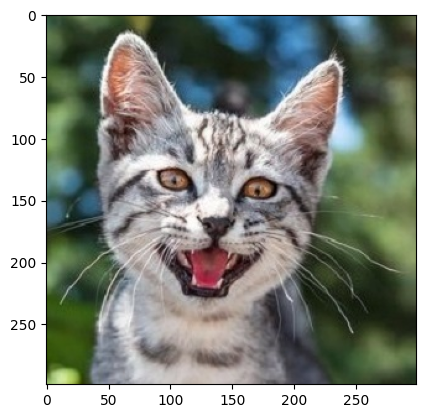

In [125]:
originalImage = loadImagePIL('cat.jpg')
print("Original shape: ", originalImage.shape)
k = Image.fromarray((originalImage*255.0).astype(np.uint8))

#expand image to create a batch of 1
originalImage = np.expand_dims(originalImage, axis=0)

originalTensor = tf.constant(originalImage)
print("Tensor shape: ", originalTensor.shape)
plt.imshow(tf.squeeze((originalTensor+1.0) * 0.5, axis=0))

### Load inception model with imagenet weights

In [126]:
model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

### Feed the image to the model and get the top 5 predictions

In [127]:
preds = model.predict(originalTensor)
predicted_top_5 = tf.keras.applications.imagenet_utils.decode_predictions(preds)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

1/1 [==============================] - 1s 1s/step


[('lynx', 0.5597929),
 ('Egyptian_cat', 0.19216381),
 ('tiger_cat', 0.05045384),
 ('tabby', 0.032717172),
 ('snow_leopard', 0.0041881828)]

### Define a target class

class id and labels can be found in: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [141]:
targetClass = 289 #485 #938
targetLabel = getImageNetLabel(targetClass)
print(targetLabel)

# the one-hot encoded label for the required target class
resOK = np.zeros((1,1000))
resOK[0][targetClass] = 1
tensorOK = tf.constant(resOK)

snow_leopard


### Get the original label

In [142]:
originalClass = np.argmax(preds)
originalLabel = getImageNetLabel(originalClass)

### Algorithm parameters and data preparation

In [143]:
steps = 100
step_size=0.001

# noise to be applied to original image
noise = np.zeros((299,299,3))

# newTensor will be the output: an adversarial image 
newTensor = originalTensor + noise


### The loss function is standard categorical cross entropy

In [131]:
@tf.function
def the_loss(y_pred, y_true):
    return tf.keras.losses.categorical_crossentropy(y_pred, y_true)
    

### The training cycle

Updating the image based on the gradients computed for the loss

In practice we update a separate noise image

In [144]:
for n in tf.range(steps):
    with tf.GradientTape() as tape:
        # must watch newTensor
        tape.watch(newTensor)
        # feed the newTensor and get predictions
        res = model(newTensor)
        #compute the loss
        loss = the_loss(res, tensorOK)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, newTensor)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    # update the noise image
    noise -= gradients*step_size
    
    # make sure the noise values remain small
    np.clip(noise,-0.001, 0.001)

    # update newTensor with noise values
    newTensor = originalTensor + noise
    #
    below = originalTensor - 2.0/255.0
    above = originalTensor + 2.0/255.0
    newTensor = tf.clip_by_value(newTensor, below, above)
    # make sure newTensor still has valid values
    newTensor = tf.clip_by_value(newTensor, -1, 1)
    
    #display stats
    
    # feed the updated image
    aux = model(newTensor)
    # get the class id and label
    topClass = np.argmax(aux)
    topLabel = getImageNetLabel(topClass)
    print("epoch: ", n.numpy(), "\t", originalLabel, aux[0][originalClass].numpy(), "\t", targetLabel, aux[0][targetClass].numpy(), "\t", topLabel, aux[0][topClass].numpy())
       
    # early stopping if we get 99% score for the target class    
    if aux[0][targetClass].numpy() > 0.99:
        break
    

epoch:  0 	 lynx 0.105006985 	 snow_leopard 0.023832837 	 Egyptian_cat 0.5814315
epoch:  1 	 lynx 0.40284267 	 snow_leopard 0.111207314 	 lynx 0.40284267
epoch:  2 	 lynx 0.054395054 	 snow_leopard 0.35372016 	 snow_leopard 0.35372016
epoch:  3 	 lynx 0.066792525 	 snow_leopard 0.64376086 	 snow_leopard 0.64376086
epoch:  4 	 lynx 0.013084282 	 snow_leopard 0.8269514 	 snow_leopard 0.8269514
epoch:  5 	 lynx 0.009262049 	 snow_leopard 0.90445775 	 snow_leopard 0.90445775
epoch:  6 	 lynx 0.002837699 	 snow_leopard 0.9421218 	 snow_leopard 0.9421218
epoch:  7 	 lynx 0.0022131386 	 snow_leopard 0.9594281 	 snow_leopard 0.9594281
epoch:  8 	 lynx 0.0013440235 	 snow_leopard 0.97056717 	 snow_leopard 0.97056717
epoch:  9 	 lynx 0.0009787222 	 snow_leopard 0.9782446 	 snow_leopard 0.9782446
epoch:  10 	 lynx 0.00072973623 	 snow_leopard 0.98314536 	 snow_leopard 0.98314536
epoch:  11 	 lynx 0.0005421471 	 snow_leopard 0.9862091 	 snow_leopard 0.9862091
epoch:  12 	 lynx 0.0004297138 	 snow_

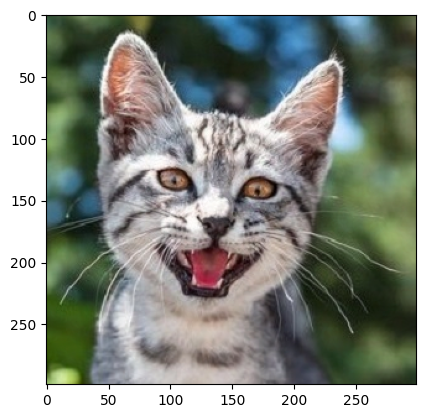

In [145]:
plt.imshow(newTensor.numpy().squeeze() * 0.5 + 0.5)

max:  0.14257446 min : -0.1115911 std : 0.008091265
Max percentage of noise: 0.07128722965717316


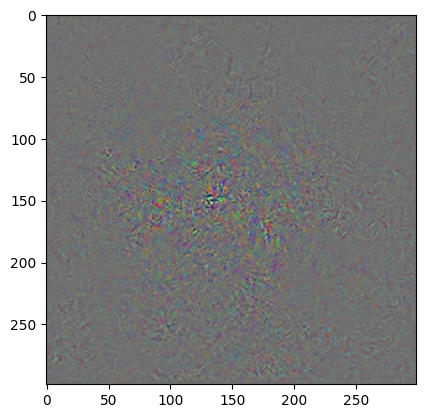

In [146]:
noise_np = noise.numpy()
noiseMax = np.max(noise_np)
noiseMin = np.min(noise_np)
noiseStd = np.std(noise_np)

print("max: ", noiseMax, "min :", noiseMin, "std :", noiseStd)
print("Max percentage of noise:", noiseMax/2)

plt.imshow((noise.numpy().squeeze()  - noiseMin  ) / (noiseMax - noiseMin)  )

### Let's see how does this fare in a different model 

This is a grey attack: we don't use the architecture information of the new net, but both models share the same training set

In [147]:
model2 = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')

#### First feed the original image and get the class
Note that since Mobilenet has an input shape (224,244,3) different from incepton (299,299,3) we first perform a image resize

In [148]:
origTensor224 = tf.image.resize(originalTensor, [224,224])
preds = model2.predict(origTensor224)


predicted_top_5 = tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=5)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

1/1 [==============================] - 1s 734ms/step


[('lynx', 0.4333137),
 ('Egyptian_cat', 0.29755905),
 ('tabby', 0.038705815),
 ('tiger_cat', 0.0371972),
 ('tiger', 0.025529984)]

#### Feed the adversarial image and get the class

There are some minor differences, yet the network is still presenting the same top5 classes

In [149]:
newTensor224 = tf.image.resize(newTensor, [224,224])
preds = model2.predict(newTensor224)
predicted_top_5 = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

1/1 [==============================] - 0s 68ms/step


[('lynx', 0.41057906),
 ('Egyptian_cat', 0.31487742),
 ('tabby', 0.043630805),
 ('tiger_cat', 0.040041465),
 ('tiger', 0.02505063)]

## Trying another model

In [150]:
model3 = tf.keras.applications.InceptionResNetV2()

#### Feed the original image

In [151]:
preds = model3.predict(originalTensor)
predicted_top_5 = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

1/1 [==============================] - 3s 3s/step


[('lynx', 0.7828808),
 ('Egyptian_cat', 0.06707166),
 ('tabby', 0.024980064),
 ('tiger_cat', 0.01753977),
 ('snow_leopard', 0.0033992014)]

In [20]:
print(preds[0][targetClass])

0.06707166


#### Feed the adversarial image

In [152]:
preds = model3.predict(newTensor)
predicted_top_5 = tf.keras.applications.imagenet_utils.decode_predictions(preds, top=5)[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

1/1 [==============================] - 0s 109ms/step


[('lynx', 0.7519453),
 ('Egyptian_cat', 0.09029787),
 ('tabby', 0.027795324),
 ('tiger_cat', 0.02055564),
 ('snow_leopard', 0.005040081)]

In [153]:
print(preds[0][targetClass])

0.005040081


In [22]:
k = tf.keras.applications.imagenet_utils.decode_predictions(
    np.zeros((1,1000)), top=1000
)
print (k)

[[('n15075141', 'toilet_tissue', 0.0), ('n02319095', 'sea_urchin', 0.0), ('n02395406', 'hog', 0.0), ('n02391049', 'zebra', 0.0), ('n02389026', 'sorrel', 0.0), ('n02364673', 'guinea_pig', 0.0), ('n02363005', 'beaver', 0.0), ('n02361337', 'marmot', 0.0), ('n02356798', 'fox_squirrel', 0.0), ('n02346627', 'porcupine', 0.0), ('n02342885', 'hamster', 0.0), ('n02328150', 'Angora', 0.0), ('n02326432', 'hare', 0.0), ('n02325366', 'wood_rabbit', 0.0), ('n02321529', 'sea_cucumber', 0.0), ('n02317335', 'starfish', 0.0), ('n02229544', 'cricket', 0.0), ('n02281787', 'lycaenid', 0.0), ('n02281406', 'sulphur_butterfly', 0.0), ('n02280649', 'cabbage_butterfly', 0.0), ('n02279972', 'monarch', 0.0), ('n02277742', 'ringlet', 0.0), ('n02276258', 'admiral', 0.0), ('n02268853', 'damselfly', 0.0), ('n02268443', 'dragonfly', 0.0), ('n02264363', 'lacewing', 0.0), ('n02259212', 'leafhopper', 0.0), ('n02256656', 'cicada', 0.0), ('n02236044', 'mantis', 0.0), ('n02233338', 'cockroach', 0.0), ('n02396427', 'wild_boa